In [180]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import poisson

First we define the problem parameters:

In [181]:
# define problem parameters
car_states = 21
move_max = 5
max_morning = car_states + move_max
gamma = .9
l_req_1, l_req_2 = 3, 4
l_ret_1, l_ret_2 = 3, 2

Here we assume that dropoffs cannot be rented out on the same day. Therefore the maximum number of satisfied request for any day is equal to the number of cars available on the morning of that day. 

In the next cell we calculate transition probabilities assuming that we may NOT move cars from one location to the other exceeding the 20 limit.

In [179]:
# # calculate transition probabilities and expected reward
# def prob_and_reward(l_req, l_ret):
    
#     states = np.arange(car_states)
#     prob = np.zeros((car_states, car_states))
#     reward = np.zeros((car_states,))
    
#     for req in range(20):
        
#         req_s = np.minimum(req, states)  # number of satisfied request
#         req_prob = poisson.pmf(req, l_req)
#         reward += req_prob*req_s*10
        
#         for ret in range(20):
#             net = ret - req_s  # net change of cars
#             net_prob = poisson.pmf(ret, l_ret)*req_prob  # probability this change happens
#             new_states = np.minimum(np.maximum(states + net, 0), car_states - 1)  # resulting new state
#             prob[states, new_states] += net_prob # update probability
            
#     return prob, reward

# prob1, reward1 = prob_and_reward(l_req_1, l_ret_1)
# prob2, reward2 = prob_and_reward(l_req_2, l_ret_2)

# # check that each row sums up to 1
# print(np.sum(prob1, axis=1)) 

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.]


Instead we may also calculate transition probabilities assuming that we are allowed move cars from one location to the other exceeding the 20 limit. However, the number may not exceed at the end of day (before deciding whether to move between locations).

The (i,j) entry of the transition matrix represents the probability of having i cars in the morning and j cars at the end of day (separate matrix for each location). Probability is calculated similarly to convolution. 

Reward only has to do with the number of cars available in the morning. We calculate the expected reward slightly modified from the poisson expectation - when number of requests is larger than number of cars in the morning, probability is computed on the former but contribution to expectation is the latter instead.

In [182]:
# calculate transition probabilities and expected reward
def prob_and_reward(l_req, l_ret):
    
    states = np.arange(max_morning)
    prob = np.zeros((max_morning, car_states))
    reward = np.zeros((max_morning,))
    
    for req in range(20):
        
        req_s = np.minimum(req, states)  # number of satisfied request
        req_prob = poisson.pmf(req, l_req)
        reward += req_prob*req_s*10
        
        for ret in range(20):
            net = ret - req_s  # net change of cars
            net_prob = poisson.pmf(ret, l_ret)*req_prob  # probability this change happens
            new_states = np.minimum(np.maximum(states + net, 0), car_states - 1)  # resulting new state
            prob[states, new_states] += net_prob # update probability
            
    return prob, reward

prob1, reward1 = prob_and_reward(l_req_1, l_ret_1)
prob2, reward2 = prob_and_reward(l_req_2, l_ret_2)

# check that each row sums up to 1
print(np.sum(prob1, axis=1)) 

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.]


Next we plot the calculated transition probability matrix for each location as well as the expected reward function based on the number of cars available in the morning.

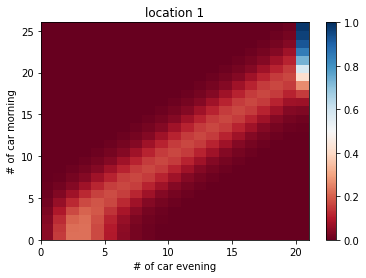

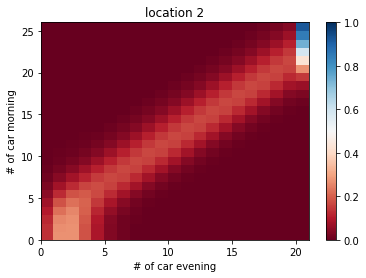

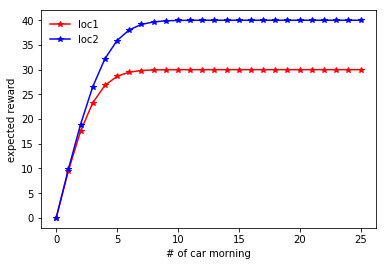

In [207]:
# plot transition probability matrix
plt.figure()
plt.pcolor(prob1, cmap='RdBu', vmin=0, vmax=1)
plt.title('location 1')
plt.xlabel('# of car evening')
plt.ylabel('# of car morning')
plt.colorbar()

plt.figure()
plt.pcolor(prob2, cmap='RdBu', vmin=0, vmax=1)
plt.title('location 2')
plt.xlabel('# of car evening')
plt.ylabel('# of car morning')
plt.colorbar()

# plot expected reward
plt.figure()
plt.plot(reward1, 'r-*', label='loc1')
plt.plot(reward2, 'b-*', label='loc2')
plt.xlabel('# of car morning')
plt.ylabel('expected reward')
plt.legend(frameon=False)

In [184]:
# calculate action value function given a state and an action
def action_value(x1, x2, move, val_func):

    x1_n = x1 - move
    x2_n = x2 + move
    
    reward_imm = -2*abs(move) + reward1[x1_n] + reward2[x2_n]
    trans_prob = np.outer(prob1[x1_n, :], prob2[x2_n, :])
    
    act_value = reward_imm + gamma*np.sum(trans_prob*val_func)
    
    return act_value


def action_value2(x1, x2, move, val_func):

    x1_n = x1 - move
    x2_n = x2 + move
    val = -2*abs(move)
    
    for i in range(car_states):
        for j in range(car_states):
            val += prob1[x1_n, i]*prob2[x2_n, j]*(reward1[x1_n] + reward2[x2_n] + gamma*val_func[i, j])
    
    return val

# one iteration of value function update with fixed policy
def val_func_iter(policy, val_func):
    
    val_func_new = np.zeros((car_states, car_states))
    
    for i in range(car_states):
        for j in range(car_states):        
            val_func_new[i, j] = action_value(i, j, policy[i, j], val_func)
            
    return val_func_new, np.max(np.abs(val_func_new - val_func))

# iteratively update value function until threshold is met
def policy_eval(policy, val_func0, thres=0.1, verbose=True):
    
    val_func = val_func0.copy()
    iters = 0
    max_update = 100
    
    while max_update > thres:
        
        val_func, max_update = val_func_iter(policy, val_func)
        iters += 1
        
    if verbose:
        print('# of iterations: ' + str(iters))
    
    return val_func


# of iterations: 126
407.17808449
611.402548629


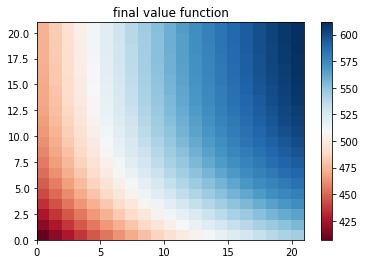

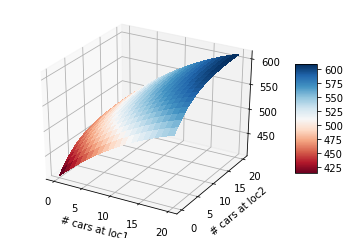

In [205]:
val_func = np.zeros((car_states, car_states))
policy = np.zeros((car_states, car_states), dtype=np.int8)

val_func = policy_eval(policy, val_func, thres=1e-4)
print(np.min(val_func))
print(np.max(val_func))

# plot value function 
plt.figure()
plt.pcolor(val_func, cmap='RdBu')
plt.title('final value function')
plt.colorbar()

fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(car_states), np.arange(car_states))
surf = ax.plot_surface(x1, x2, val_func, cmap='RdBu',
                       linewidth=0, antialiased=False)
# ax.view_init(20, 20)
ax.set_xlabel('# cars at loc1')
ax.set_ylabel('# cars at loc2')
fig.colorbar(surf, shrink=0.5, aspect=5)

Next we define the greedy policy improvement algorithm. The value function is fixed and for each state, we iterate all possible actions and calculate correponding action-value function. The one giving the maximum value is selected to be the action to take for the new policy.

Policy for 324 states changed.
False
-4


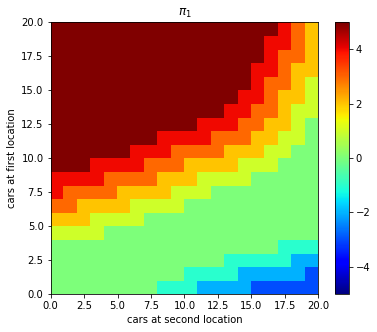

In [206]:
def policy_improve(policy, val_func, verbose=True):
    
    policy_new = policy.copy()
    stable = True
    
    for i in range(car_states):
        for j in range(car_states):
            
            val_best = -999
            
            # define range of valid policy/move
            # a_max = min(move_max, i, 20 - j)
            # a_min = max(-move_max, -j, -20 + i)

            a_max = min(move_max, i)
            a_min = max(-move_max, -j)
            
            for move in np.arange(a_min, a_max + 1):
                
                act_val = action_value(i, j, move, val_func)
                    
                if act_val > val_best:
                    val_best = act_val
                    policy_new[i, j] = move

    stable = np.array_equal(policy, policy_new)
    if verbose:
        print('Policy for '+str(np.sum(policy != policy_new))+' states changed.')
    
    return policy_new, stable
    
policy, stable = policy_improve(policy, val_func)
print(stable)
print(policy[0, 20])  # 0@loc1, 20@loc2

# plot new policy
x1, x2 = np.meshgrid(np.arange(21), np.arange(21))

plt.figure(figsize=(6, 5))
plt.pcolor(x1, x2, policy, cmap='jet', vmax=5, vmin=-5)
plt.title(r'$\pi_1$')
plt.xlabel('cars at second location')
plt.ylabel('cars at first location')
plt.colorbar()

# of iterations: 126
Policy for 324 states changed.
# of iterations: 91
Policy for 278 states changed.
# of iterations: 80
Policy for 81 states changed.
# of iterations: 45
Policy for 8 states changed.
# of iterations: 14
Policy for 0 states changed.
# of eval-improve iterations: 5
max: 636.989203832
min: 421.413817527


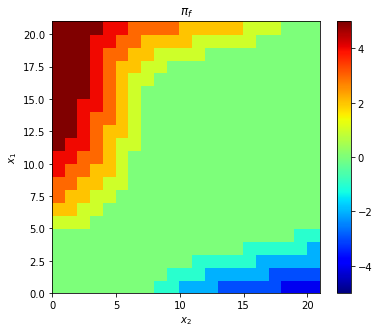

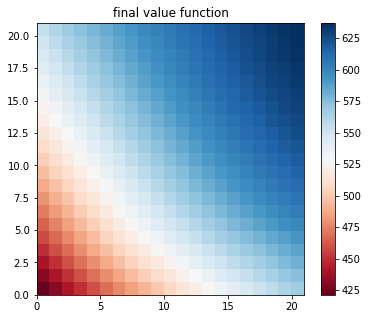

In [201]:
val_func = np.zeros((car_states, car_states))
policy = np.zeros((car_states, car_states), dtype=np.int8)

stable = False
iters = 0

while not stable:
    
    val_func = policy_eval(policy, val_func, thres=1e-4, verbose=True)
    policy, stable = policy_improve(policy, val_func)
    
    iters += 1
    
print('# of eval-improve iterations: ' + str(iters))

# plot final policy
plt.figure(figsize=(6, 5))
plt.pcolor(policy, cmap='jet', vmax=5, vmin=-5)
plt.title(r'$\pi_f$')
plt.xlabel(r'$x_2$')
plt.ylabel(r'$x_1$')
plt.colorbar()

# plot final value function
plt.figure(figsize=(6, 5))
plt.pcolor(val_func, cmap='RdBu')
plt.title('final value function')
plt.colorbar()

print('max: '+str(np.amax(val_func)))
print('min: '+str(np.amin(val_func)))